In [2]:
from transformers import AutoProcessor, OwlViTForObjectDetection, AutoModelForZeroShotObjectDetection
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def display_image(image):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
def display_bbox(boxes, image):
    """
    boxes: list of boxes, each box is a list of 4 numbers: x1, y1, x2, y2
    image: a numpy array of shape (m, n, 3), the target image
    """
    image = image.copy()
    # print(type(boxes[0][0]))
    # return
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    plt.axis('off')
    plt.imshow(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1281x698 at 0x22A324600D0>


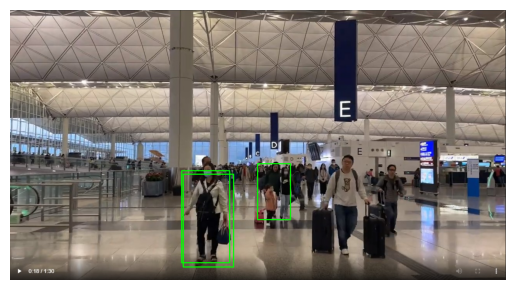

In [6]:
query = [['woman with black backpack']]

checkpoint = "google/owlvit-base-patch32"
image = Image.open('data/man_with_suitcase.jpg')
print(image)
processor = AutoProcessor.from_pretrained(checkpoint)
inputs = processor(text=query, images=image, return_tensors='pt')
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
outputs = model(**inputs)

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.05,target_sizes=target_sizes)

display_bbox(results[0]['boxes'].tolist(), np.array(image))

## Image Querying

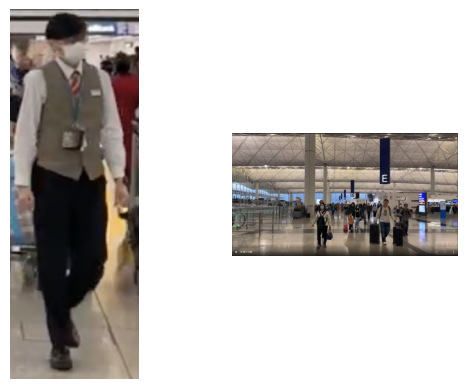

In [74]:
query_url = 'test_images/suitcase_mask_man.jpg'
query_image = Image.open(query_url)

input_url = 'data/man_with_suitcase.jpg'
input_image = Image.open(input_url)

fig, ax = plt.subplots(1, 2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(query_image)
ax[1].imshow(input_image)

In [75]:
# from transformers import OwlVitProcessor
# owl_processor = OwlVitProcessor.from_pretrained("google/owlvit-base-patch32")
inputs = processor(images=input_image, query_images=query_image, return_tensors="pt").to('cuda')
for key, val in inputs.items():
    print(key,val.shape)

query_pixel_values torch.Size([1, 3, 768, 768])
pixel_values torch.Size([1, 3, 768, 768])


In [76]:
model = model.to('cuda')
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)

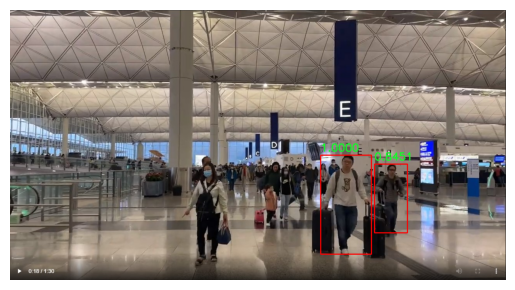

In [77]:
img = cv2.cvtColor(np.array(input_image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.to('cpu')
outputs.target_pred_boxes = outputs.target_pred_boxes.to('cpu')

results = processor.post_process_image_guided_detection(outputs, threshold=0.8, nms_threshold=0.3, target_sizes=torch.Tensor([input_image.size[::-1]]))
boxes, scores = results[0]['boxes'], results[0]['scores']
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
    cv2.putText(img, f'{score.tolist():.4f}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

plt.axis('off')
plt.imshow(img[:,:,::-1])